In [27]:
import requests
from google.cloud import translate
from google.cloud import language_v1
from google.oauth2 import service_account

In [28]:
# Twitter:
bearer = open("./bearer_token.txt").read().strip()

# Google cloud:
PROJECT_ID = open("project_id.txt").read().strip()
parent=f"projects/{PROJECT_ID}/locations/global"
credentials = service_account.Credentials.from_service_account_file('credentials.json')

client = language_v1.LanguageServiceClient(credentials=credentials)
translate_client = translate.TranslationServiceClient(credentials=credentials)

In [29]:
text_type = language_v1.Document.Type.PLAIN_TEXT
language = "en"
encoding_type = language_v1.EncodingType.UTF8

In [224]:
def run_pipeline(hashtags=["covid"], language="pl", translate_client=translate_client, sentiment_client=client, parent=parent, max_results=10):
    tweets = get_tweets(lang=language, hashtags=hashtags, max_results=max_results)
    if language == "en":
        return get_sentiments(tweets, tweets)
    
    translations = translate_tweets(tweets, language=language)
    sentiments = get_sentiments(tweets, translations)
    return sentiments
    
    
def translate_tweets(tweets, language="pl", translate_client=translate_client):
    r_translate = translate_client.translate_text(request = {
        "parent": parent,
        "contents": tweets,
        "source_language_code": language,
        "target_language_code": 'en',
        "mime_type": 'text/plain'
    })
    return [r.translated_text for r in r_translate.translations]
    
    
def get_sentiments(tweets, translations, sentiment_client=client):
    results = []
    sentiments = []
    for text in translations:
        document = {"content": text, "type_": text_type, "language": language}
        response = client.analyze_sentiment(request = {'document': document, 'encoding_type': encoding_type})
        results.append(response)
        decision = 1 if response.document_sentiment.score > 0.1 else \
                   0 if response.document_sentiment.score >= -0.1 else \
                   -1        
        sentiments.append(decision)
    sentences = [sentence for r in results for sentence in r.sentences]
    mostPosId, mostPosRes = max(enumerate(results), key = lambda d: d[1].document_sentiment.score)
    mostNegId, mostNegRes = min(enumerate(results), key = lambda d: d[1].document_sentiment.score)
    return {
        'sentiments' : sentiments,
        'mostPositiveText': (mostPosRes, tweets[mostPosId], translations[mostPosId]),
        'mostNegativeText': (mostNegRes, tweets[mostNegId], translations[mostNegId]),
        'mostPositiveSentence': max(sentences, key = lambda s: s.sentiment.score),
        'mostNegativeSentence': min(sentences, key = lambda s: s.sentiment.score),
    }

def get_tweets(hashtags=["covid", "coronavirus", "koronawirus", "pandemia", "pandemic"], keywords=[], lang="pl", bearer=bearer, no_retweets=True, additional="", max_results=10):
    endpoint = f"https://api.twitter.com/2/tweets/search/recent?query="
    
    query = '(' + ' OR '.join(hashtags) + ') '
    endpoint += query
        
    for k in keywords:
        endpoint += k+" "
    
    endpoint += "lang:"+lang+" "
    
    if no_retweets:
        endpoint += "-is:retweet "
    
    endpoint += additional+" "
    
    headers = {"Authorization": f"Bearer {bearer}"}
    
    endpoint += f"&max_results={max_results}"
    r = requests.get(endpoint.encode("utf-8"), headers=headers).json()
    return [data["text"] for data in r['data']]

# Demo

In [50]:
r = get_tweets()

In [32]:
r

['+ Do tego click &amp; collect ma być ograniczone tylko do najpotrzebniejszych artykułów, a jednym z nich ponoć NIE JEST kawa! 😡😡😡\nAaa i jeszcze zakaz spożycia alkoholu poza domem. Całkowity.\n\n#KORONAWIRUS #COVID19 #Covid_19 #COVID #PANDEMIA #ZARAZA #LOCKDOWN #LockdownUK',
 'A co tam słychać w europejskich więzieniach?\n\nW Szkocji Nicola Królowa Lockdownów zakazała wydawania posiłków na wynos w lokalach. Tylko przez próg, jak psu, lub przez okienko, jak w budce z kebabem.\n\n#KORONAWIRUS #COVID19 #Covid_19 #COVID #PANDEMIA #ZARAZA #LOCKDOWN #LockdownUK',
 'W Chinach nie ma już #COVID, a pomimo tego mieszkańcy niektórych miast zamykani są na tydzień w domu i nadal noszą maseczki. #Chińczycy dmuchają na zimne? https://t.co/PDtbm5gt7Q',
 'Osoby, które przyjęły pierwszą dawkę szczepionki @pfizer i @BioNTech_Group o 33% rzadziej otrzymują pozytywny wynik testu na obecność #koronawirus po 2 tygodniach od zaszczepienia od osób, które nie otrzymały podobnej ochrony.\n\n#COVID19 #COVID #Iz

In [33]:
t = translate_tweets(r, language="pl")

In [34]:
t

['+ Plus click & amp; collect is to be limited only to the most necessary items, and one of them is NOT coffee! 😡😡😡\nOh, and the ban on drinking alcohol outside the home. Total.\n\n#CORONAVIRUS # COVID19 # Covid_19 #COVID #PANDEMIA #ZARAZA #LOCKDOWN #LockdownUK',
 "What's up in European prisons?\n\nIn Scotland, Nicola, the Queen of Lockdowns, has banned out-of-the-box takeaways. Only through the threshold, like a dog, or through the window, like in a kebab booth.\n\n#CORONAVIRUS # COVID19 # Covid_19 #COVID #PANDEMIA #ZARAZA #LOCKDOWN #LockdownUK",
 'There is no more #COVID in China, yet some city dwellers are locked up at home for a week and still wear face masks. # The Chinese are blowing it cold? https://t.co/PDtbm5gt7Q',
 'People who took the first dose of @pfizer and @BioNTech_Group were 33% less likely to test positive for #coronavirus 2 weeks after vaccination from those who did not receive similar protection.\n\n# COVID19 #COVID #Israel\nhttps://t.co/1GlEgSiHER',
 'Shield 6.0 ex

In [35]:
s = get_sentiments(t)

In [36]:
s

[0, 0, 0, 0, 1, 1, 0, 0, 0, 1]

In [37]:
def get_name(n):
    if n==1:
        return "Positive"
    return "Negative"

In [38]:
summary = [f"Original tweet: {tweet}\n Translated tweet: {translation}\n Sentiment: {get_name(sentiment)}" for tweet, translation, sentiment in zip(r, t, s)]

In [39]:
for s in summary[:4]:
    print(s)
    print()

Original tweet: + Do tego click &amp; collect ma być ograniczone tylko do najpotrzebniejszych artykułów, a jednym z nich ponoć NIE JEST kawa! 😡😡😡
Aaa i jeszcze zakaz spożycia alkoholu poza domem. Całkowity.

#KORONAWIRUS #COVID19 #Covid_19 #COVID #PANDEMIA #ZARAZA #LOCKDOWN #LockdownUK
 Translated tweet: + Plus click & amp; collect is to be limited only to the most necessary items, and one of them is NOT coffee! 😡😡😡
Oh, and the ban on drinking alcohol outside the home. Total.

#CORONAVIRUS # COVID19 # Covid_19 #COVID #PANDEMIA #ZARAZA #LOCKDOWN #LockdownUK
 Sentiment: Negative

Original tweet: A co tam słychać w europejskich więzieniach?

W Szkocji Nicola Królowa Lockdownów zakazała wydawania posiłków na wynos w lokalach. Tylko przez próg, jak psu, lub przez okienko, jak w budce z kebabem.

#KORONAWIRUS #COVID19 #Covid_19 #COVID #PANDEMIA #ZARAZA #LOCKDOWN #LockdownUK
 Translated tweet: What's up in European prisons?

In Scotland, Nicola, the Queen of Lockdowns, has banned out-of-the-b

# Whole pipeline:

### Sentiments in Poland:

In [208]:
r = run_pipeline(language = 'pl')

### Sentiments in Spain:

In [209]:
r = run_pipeline(language = 'es')

## Languages
English (default) en  
Arabic  ar  
Bengali bn  
Czech cs  
Danish  da  
German  de  
Greek el  
Spanish es  
Persian fa  
Finnish fi  
Filipino  fil  
French  fr  
Hebrew  he  
Hindi hi  
Hungarian hu  
Indonesian  id  
Italian it  
Japanese  ja  
Korean  ko  
Malay msa  
Dutch nl  
Norwegian no  
Polish  pl  
Portuguese  pt  
Romanian  ro  
Russian ru  
Swedish sv  
Thai  th  
Turkish tr  
Ukrainian uk  
Urdu  ur  
Vietnamese  vi  
Chinese (Simplified)  zh-cn  
Chinese (Traditional) zh-tw  

In [53]:
import time
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")

In [197]:
def plot_sentiments(results, hashtags):
    formatted_data = []
    columns=["country", "percentPos", "percentNeut", "percentNeg"]
    
    for language, data in results.items():
        allNumber = len(data)
        positiveNumber = len(list(filter(lambda f: f == 1, data)))
        neutralNumber = len(list(filter(lambda f: f == 0, data)))
        negativeNumber = len(list(filter(lambda f: f == -1, data)))
        positivePerc = (positiveNumber / allNumber * 100) if positiveNumber != 0 else 0
        neutralPerc = (neutralNumber / allNumber * 100) if neutralNumber != 0 else 0
        negativePerc = (negativeNumber / allNumber * 100) if negativeNumber != 0 else 0    
        formatted_data.append((language, positivePerc, neutralPerc, negativePerc))
        
    df = pd.DataFrame(formatted_data, columns=columns)
    
    df.plot( 
      x = 'country',  
      kind = 'barh',  
      stacked = True,  
      title = f'Sentiment for tweets with hashtags: {hashtags} per country',
      mark_right = True,
      color=['g', 'b', 'r'],
     figsize=(14,8))
    plt.legend(["Percent of positive tweets", "Percent of neutral tweets", "Percent of negative tweets"])
    
    

In [225]:
from IPython.display import Markdown, display

def analyze_twitter(languages, hashtags=["covid"], streaming=False):
    results = {}
    
    while True:
        clear_output(wait=True)
        for language in languages:
            pipelineResults = run_pipeline(language=language, hashtags=hashtags, max_results=50)
            results[language] = pipelineResults['sentiments']

            mostPosScore = round(pipelineResults['mostPositiveText'][0].document_sentiment.score, 2)
            mostPosOriginalText = pipelineResults['mostPositiveText'][1]
            mostPosEnText = pipelineResults['mostPositiveText'][2]
            mostNegScore = round(pipelineResults['mostNegativeText'][0].document_sentiment.score, 2)
            mostNegOriginalText = pipelineResults['mostNegativeText'][1]
            mostNegEnText = pipelineResults['mostNegativeText'][2]
            mostPosSentenceScore = round(pipelineResults['mostPositiveSentence'].sentiment.score, 2)
            mostPosSentenceEnText = pipelineResults['mostPositiveSentence'].text.content
            mostNegSentenceScore = round(pipelineResults['mostNegativeSentence'].sentiment.score, 2)
            mostNegSentenceEnText = pipelineResults['mostNegativeSentence'].text.content
            
            display(Markdown(f'**Language: {language}**<br>**Most positive tweet ({mostPosScore}):**<br>{mostPosOriginalText}<br>{mostPosEnText}<br>'))
            display(Markdown(f'**Most negative tweet ({mostNegScore}):**<br>{mostNegOriginalText}<br>{mostNegEnText}<br>'))
            display(Markdown(f'**Most positive sentence ({mostPosSentenceScore}):**<br>{mostPosSentenceEnText}<br>'))
            display(Markdown(f'**Most negative sentence ({mostNegSentenceScore}):**<br>{mostNegSentenceEnText}<br>'))
            print()
            
        plot_sentiments(results, hashtags)
        if not streaming:
            return
        plt.show()
        time.sleep(10)
        

**Language: pl**<br>**Most positive tweet (0.6):**<br>Best in COVID. Ja som najpepci kridzovy manazer a nikto to nuriadi dobre, jen ja, ja nech si to fseci zapametaju. https://t.co/OMkIuvLVpT<br>Best in COVID. I am the best of the Kridzovy manager and Nikto is a good nuriadi, I am not a fist. https://t.co/OMkIuvLVpT<br>

**Most negative tweet (-0.8):**<br>@marwinhit twierdzi ze to czy zachoruje na covid to jest decyzja boga<br>@marwinhit says it is god's decision to get sick with covid<br>

**Most positive sentence (0.9):**<br>Best in COVID.<br>

**Most negative sentence (-0.8):**<br>However, this order causes internal problems for the ruling Erdoğan.<br>

**Language: en**<br>**Most positive tweet (0.5):**<br>Our friends in Cape Breton saw an increase in demand for homes in 2020, with buyers coming from across Nova Scotia, and beyond. https://t.co/RAgNzlmDhh<br>Our friends in Cape Breton saw an increase in demand for homes in 2020, with buyers coming from across Nova Scotia, and beyond. https://t.co/RAgNzlmDhh<br>

**Most negative tweet (-0.8):**<br>@DavidNdii @GovWOparanya Oparanya this is such reckless pronouncement. Healthcare workers sacrificed themselves and families to fight covid. And you are talking nonsense!<br>@DavidNdii @GovWOparanya Oparanya this is such reckless pronouncement. Healthcare workers sacrificed themselves and families to fight covid. And you are talking nonsense!<br>

**Most positive sentence (0.9):**<br>@JacobJaber YES YES YES!<br>

**Most negative sentence (-0.9):**<br>And you are talking nonsense!<br>

**Language: de**<br>**Most positive tweet (0.4):**<br>@_FriedrichMerz @ZDF @EvaQuadbeck Es gibt eine bis zu 100% sichere Brücke zur Impfung! 

Bitte weiterleiten an Ärzte, insbesondere auf Intensivstationen!

Die Protokolle können zusätzlich zur Prophylaxe verwendet werden!

https://t.co/StXxKy8PGC

Hintergrundinformationen siehe Thread unten:https://t.co/yOtNBoFVCE https://t.co/oQPnK6z2Td<br>@_FriedrichMerz @ZDF @EvaQuadbeck There is a 100% safe bridge to vaccination!

Please forward to doctors, especially in intensive care units!

The protocols can also be used for prophylaxis!

https://t.co/StXxKy8PGC

For background information, see the thread below: https: //t.co/yOtNBoFVCE https://t.co/oQPnK6z2Td<br>

**Most negative tweet (-0.7):**<br>@reitschuster Dem Glauben muss man Fakten entgegen setzen. 
https://t.co/4ICj2dYCaJ
Die #Corona-Panik ist ein ideologisches Konstrukt, um die gegenwärtige Gesellschaftsordnung zu zerstören.<br>@reitschuster Faith has to be countered with facts.
https://t.co/4ICj2dYCaJ
The #corona panic is an ideological construct to destroy the current social order.<br>

**Most positive sentence (0.9):**<br>This topic is close to my heart.<br>

**Most negative sentence (-0.9):**<br>The Red Cross hypocrite spreads fear and terror among people for no reason and without any evidence!<br>

**Language: fr**<br>**Most positive tweet (0.9):**<br>@Francois_Ruffin merci François, j'ai 3 enfants, 2 post bac et un lyceen..et je suis infirmier psy ( j'ai aussi été positif covid comme un de mes gosses)... Merci François de penser a eux, de parler pour eux..tu m'as foutu les larmes aux yeux...Merci François....<br>@Francois_Ruffin thank you François, I have 3 children, 2 post-bac and a high school student .. and I am a psych nurse (I was also positive covid as one of my kids) ... Thank you François for thinking of them, for talking for them..you brought tears to my eyes ... Thank you François ....<br>

**Most negative tweet (-0.8):**<br>@SagittariusHH Le gars il se sent plus agressé par un voisin bronzé que par le COVID.<br>@SagittariusHH The guy he feels assaulted more by a tanned neighbor than by COVID.<br>

**Most positive sentence (0.9):**<br>@DrManaouda Hello excellence.<br>

**Most negative sentence (-0.8):**<br>@SagittariusHH The guy he feels assaulted more by a tanned neighbor than by COVID.<br>

**Language: ru**<br>**Most positive tweet (0.5):**<br>Наконец-то. https://t.co/2MH0RgjNwU<br>At last. https://t.co/2MH0RgjNwU<br>

**Most negative tweet (-0.8):**<br>Хакеры слили в сеть похищенные данные о COVID-вакцинах Pfizer и Moderna
https://t.co/E5JGbQattK https://t.co/cv7gxKUuBq<br>Hackers leaked stolen data on Pfizer and Moderna COVID vaccines
https://t.co/E5JGbQattK https://t.co/cv7gxKUuBq<br>

**Most positive sentence (0.8):**<br>Everything you need to know about mass vaccination in Russia<br>

**Most negative sentence (-0.9):**<br>"It's worse than World War II."<br>

**Language: zh**<br>**Most positive tweet (0.3):**<br>إن رزقت بالصحة قدم الخير للآخرين بقدر ما تستطيع .💖🙏💖
If you earn health, do good to others as much as you can .
如果您能健康，就尽可能多地对他人好 。

#تحديات فترة Covid 19 #<br>إن رزقت بالصحة قدم الخير للآخرين بقدر ما تستطيع .💖🙏💖
If you earn health, do good to others as much as you can.
If you are healthy, treat others as much as possible.

#تحديات فترة Covid 19 #<br>

**Most negative tweet (-0.8):**<br>川普政府将抛出“重磅炸弹”——病毒是中共制造 
Trump team will blame China lab for growing Covid-19 https://t.co/m4ClIkSELi via @MailOnline<br>The Trump administration will throw a "blockbuster"-the virus is made by the CCP
Trump team will blame China lab for growing Covid-19 https://t.co/m4ClIkSELi via @MailOnline<br>

**Most positive sentence (0.9):**<br>Authentic, conservative and traditional.<br>

**Most negative sentence (-0.9):**<br>We feel afraid of COVID-19.<br>

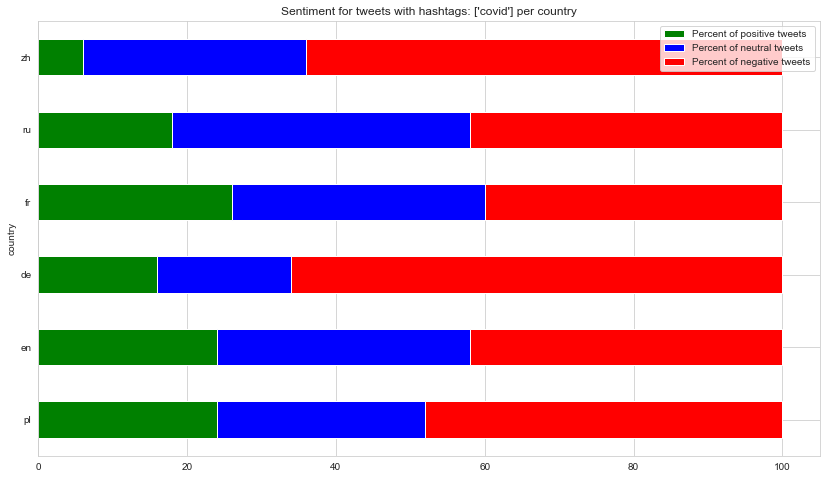

In [226]:
analyze_twitter(['pl', 'en', 'de', 'fr', 'ru', 'zh'], ["covid"])

In [ ]:
analyze_twitter(['pl', 'en', 'de', 'fr', 'ru', 'zh'], ["trump"])

**Language: pl**<br>**Most positive tweet (0.4):**<br>@Anna13710076 Tu każdy znaczy tyle samo. Nawet Trump ;)<br>@ Anna13710076 Here everyone means the same. Even Trump;)<br>

**Most negative tweet (-0.8):**<br>To, że Trump będzie jedynym prezydentem USA dwukrotnie poddanym impeachmentowi, nie wydaje świadectwa jemu - raczej Partii Republikańskiej, która nie skorzystała z okazji do odcięcia się od swoich błędów.<br>The fact that Trump will be the only U.S. president who has been impeached twice does not bear witness to him - rather, to the Republican Party that did not take the opportunity to distance itself from its mistakes.<br>

**Most positive sentence (0.9):**<br>McConnell plays it beautifully ...<br>

**Most negative sentence (-0.9):**<br>@ EmilBrunner1 Because you're stupid.<br>

**Language: en**<br>**Most positive tweet (0.3):**<br>@dopre @mikeoffoftheuk @BreitbartNews Trump has been more than a TV star and his show was more worthwhile than stupid phoney baloney liberal reality shows like The Bachelor and Survivor.<br>@dopre @mikeoffoftheuk @BreitbartNews Trump has been more than a TV star and his show was more worthwhile than stupid phoney baloney liberal reality shows like The Bachelor and Survivor.<br>

**Most negative tweet (-0.9):**<br>@CNN @lukemcgee Trump is a piece of shit.<br>@CNN @lukemcgee Trump is a piece of shit.<br>

**Most positive sentence (0.9):**<br>Really interesting if true.<br>

**Most negative sentence (-0.9):**<br>She is an embarrassment to the US<br>

**Language: de**<br>**Most positive tweet (0.3):**<br>#Trump ist einfach der Beste. Mit seinem schlechten Wahlkampf, dem völlig uninformiert sein über Fake und echte Wahlmanipulationen und seinem völligen Vergeigen am 06.01. hat er allen die Chance gegeben, sich von ihm zu lösen. Er ist der Beste.<br>#Trump is just the best. With his bad election campaign, being completely uninformed about fake and real election manipulation and his complete messing up on January 6th. he gave everyone the chance to break away from him. He is the best.<br>

**Most negative tweet (-0.8):**<br>@tazgezwitscher Biden bekommt bei seiner Veidigung keinen roten Teppich ausgerollt, sondern einen Teppich voller Leichen, die Trump durch seine Ignoranz, Verleumdungen u. Lügen, Hetze u. Hass hinterlässt. Ehrlich, auf diesen Teppich möchte ich nicht gehen.<br>@tazgezwitscher Biden does not get a red carpet rolled out during his defense, but a carpet full of corpses that Trump leaves behind through his ignorance, slander and lies, agitation and hatred. Honestly, I don't want to walk on this carpet.<br>

**Most positive sentence (0.9):**<br>#Trump is just the best.<br>

**Most negative sentence (-0.9):**<br>Trump should be ashamed!<br>

**Language: fr**<br>**Most positive tweet (0.9):**<br>@Trump_Fact_News @herve_ferrant Remercions les d’être là pour nous 🙏<br>@Trump_Fact_News @herve_ferrant Thank them for being there for us 🙏<br>

**Most negative tweet (-0.7):**<br>si Trump n'est pas destitué, je ne vois pas qu'est-ce qui pourrait permettre une destitution d'un prochain Président des États-Unis dans le future, il me semble que Trump coche toutes les cases<br>if Trump is not impeached I do not see what could lead to impeachment of a next President of the United States in the future, it seems to me that Trump ticks all the boxes<br>

**Most positive sentence (0.9):**<br>@Trump_Fact_News @herve_ferrant Thank them for being there for us 🙏<br>

**Most negative sentence (-0.9):**<br>@PatriceRoyTJ then where are all your Republicans who voted for the impeachment of Trump I would be embarrassed of your FakeNews to manipulate people less stingy with the search for the truth ...<br>